In [1]:
#Importing Libraries
import pandas as pd
import os
import numpy as np
import pandas as pd # to import csv and for data manipulation
import matplotlib.pyplot as plt # to plot graph
import seaborn as sns # for intractve graphs
import numpy as np # for linear algebra
import datetime # to dela with date and time
%matplotlib inline
from sklearn.preprocessing import StandardScaler # for preprocessing the data
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from sklearn.tree import DecisionTreeClassifier # for Decision Tree classifier
from sklearn.svm import SVC # for SVM classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split # to split the data
from sklearn.model_selection import KFold # For cross vbalidation
from sklearn.model_selection import GridSearchCV # for tunnig hyper parameter it will use all combination of given parameters
from sklearn.model_selection import RandomizedSearchCV # same for tunning hyper parameter but will use random combinations of parameters
from sklearn.metrics import confusion_matrix,recall_score,precision_recall_curve,auc,roc_curve,roc_auc_score,classification_report
import pandas  as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.linear_model import LogisticRegression 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
import warnings
warnings.filterwarnings("ignore")

# Reading Datasets

In [2]:
telemetry = pd.read_csv('PdM_telemetry.csv')
errors = pd.read_csv('PdM_errors.csv')
maint = pd.read_csv('PdM_maint.csv')
failures = pd.read_csv('PdM_failures.csv')
machines = pd.read_csv('PdM_machines.csv')

#format datetime field which comes in as string in telemetry
telemetry['datetime'] = pd.to_datetime(telemetry['datetime'], format="%Y-%m-%d %H:%M:%S")
#Print total number of records in telemetry
print('Total number of telemetry records: {}'.format(len(telemetry.index)))

# format datetime field which comes in as string in Errors
errors['datetime'] = pd.to_datetime(errors['datetime'], format="%Y-%m-%d %H:%M:%S")
errors['errorID'] = errors['errorID'].astype('category')
#Print total number of records in Errors
print('Total number of error records: {}'.format(len(errors.index)))

# format datetime field which comes in as string in Maint
maint['datetime'] = pd.to_datetime(maint['datetime'], format="%Y-%m-%d %H:%M:%S")
maint['comp'] = maint['comp'].astype('category')
print('Total number of maintenance records: {}'.format(len(maint.index)))

#Machine details
machines['model'] = machines['model'].astype('category')
print('Total number of machines: {}'.format(len(machines.index)))

# format datetime field which comes in as string
failures['datetime'] = pd.to_datetime(failures['datetime'], format="%Y-%m-%d %H:%M:%S")
failures['failure'] = failures['failure'].astype('category')
print('Total number of failures: {}'.format(len(failures.index)))

Total number of telemetry records: 876100
Total number of error records: 3919
Total number of maintenance records: 3286
Total number of machines: 100
Total number of failures: 761


# Feature Engineering

In [3]:
#Define interval
Hours='24H'

In [4]:
# Calculate mean values for telemetry features
temp = []
fields = ['volt', 'rotate', 'pressure', 'vibration']
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours, closed='left', label='right').mean(). unstack())
telemetry_mean_24h = pd.concat(temp, axis=1)
telemetry_mean_24h.columns = [i + 'mean_24h' for i in fields]
telemetry_mean_24h.reset_index(inplace=True)

# repeat for standard deviation
temp = []
for col in fields:
    temp.append(pd.pivot_table(telemetry,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours, closed='left', label='right').std().unstack())
telemetry_sd_24h = pd.concat(temp, axis=1)
telemetry_sd_24h.columns = [i + 'sd_24h' for i in fields]
telemetry_sd_24h.reset_index(inplace=True)

telemetry_mean_24h.head()

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h
0,1,2015-01-02,167.576533,440.515328,98.522345,40.049623
1,1,2015-01-03,169.795758,446.832666,98.454608,39.271645
2,1,2015-01-04,171.862244,459.204742,97.998233,48.074091
3,1,2015-01-05,174.792428,448.743201,101.452266,52.190268
4,1,2015-01-06,171.018408,454.822750,102.363114,43.330311


In [5]:
# merge columns of feature sets created earlier
telemetry_feat = pd.concat([telemetry_mean_24h,
                            telemetry_sd_24h.ix[:, 2:6]], axis=1).dropna()
telemetry_feat.describe()

,machineID,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h
count,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000
mean,50.500000,170.783909,446.597876,100.862200,40.385859,14.917325,49.974863,10.055523,5.004178
std,28.866464,4.742845,18.027200,4.737943,2.056052,2.271434,7.717842,1.732882,0.807409
min,1.000000,155.957840,271.246607,89.367253,35.420728,6.319415,13.730158,4.513850,1.490563
25%,25.750000,168.045088,441.480566,98.679026,39.365870,13.347621,44.716677,8.920414,4.462105
50%,50.500000,170.214746,449.164118,100.113825,40.071720,14.844968,49.597242,9.920475,4.958842
75%,75.250000,172.489968,456.346770,101.610695,40.832505,16.423938,54.877603,10.992131,5.487008
max,100.000000,218.265191,493.381312,152.314600,61.113082,28.297825,101.437628,28.399538,10.518458


In [6]:
# create a column for each error type
error_count = pd.get_dummies(errors)
error_count.columns = ['datetime', 'machineID', 'error1', 'error2', 'error3', 'error4', 'error5']

# combine errors for a given machine in a given hour
error_count = error_count.groupby(['machineID', 'datetime']).sum().reset_index()
error_count.head()

#Merge 2 datasets, telemetry and errors
error_count = telemetry[['datetime', 'machineID']].merge(error_count, on=['machineID', 'datetime'], how='left').fillna(0.0)
error_count.describe()

,machineID,error1,error2,error3,error4,error5
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,0.001153,0.001128,0.000957,0.000830,0.000406
std,28.866087,0.033934,0.033563,0.030913,0.028795,0.020154
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
temp = []
fields = ['error%d' % i for i in range(1,6)]
for col in fields:
    temp.append(pd.pivot_table(error_count,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours,closed='left',label='right').sum().unstack())
error_count = pd.concat(temp, axis=1)
error_count.columns = [i + 'count' for i in fields]
error_count.reset_index(inplace=True)
error_count = error_count.dropna()
error_count.describe()

,machineID,error1count,error2count,error3count,error4count,error5count
count,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000,36600.000000
mean,50.500000,0.027596,0.026995,0.022896,0.019863,0.009727
std,28.866464,0.166297,0.164413,0.151029,0.141091,0.098700
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,75.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,2.000000,2.000000,2.000000,2.000000,2.000000


In [8]:
# create a column for each error type
failures_count = pd.get_dummies(failures)
failures_count.columns = ['datetime', 'machineID',  'Fail-comp1', 'Fail-comp2', 'Fail-comp3', 'Fail-comp4']

# combine errors for a given machine in a given hour
failures_count = failures_count.groupby(['machineID', 'datetime']).sum().reset_index()
failures_count.head()

,machineID,datetime,Fail-comp1,Fail-comp2,Fail-comp3,Fail-comp4
0,1,2015-01-05 06:00:00,0,0,0,1
1,1,2015-03-06 06:00:00,1,0,0,0
2,1,2015-04-20 06:00:00,0,1,0,0
3,1,2015-06-19 06:00:00,0,0,0,1
4,1,2015-09-02 06:00:00,0,0,0,1


In [9]:
failures_count = telemetry[['datetime', 'machineID']].merge(failures_count, on=['machineID', 'datetime'])#, how='left')
failures_count.describe()

,machineID,Fail-comp1,Fail-comp2,Fail-comp3,Fail-comp4
count,719.000000,719.000000,719.000000,719.000000,719.000000
mean,52.349096,0.267038,0.360223,0.182197,0.248957
std,29.362194,0.442720,0.480399,0.386276,0.432710
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,24.000000,0.000000,0.000000,0.000000,0.000000
50%,52.000000,0.000000,0.000000,0.000000,0.000000
75%,79.000000,1.000000,1.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000


In [10]:
temp = []
fields = ['Fail-comp1', 'Fail-comp2', 'Fail-comp3', 'Fail-comp4']
for col in fields:
    temp.append(pd.pivot_table(failures_count,
                               index='datetime',
                               columns='machineID',
                               values=col).resample(Hours,closed='left',
                               label='right').sum().unstack())
failures_count = pd.concat(temp, axis=1)
failures_count.columns = ['Fail-comp1', 'Fail-comp2', 'Fail-comp3', 'Fail-comp4']
failures_count.reset_index(inplace=True)
failures_count = failures_count.dropna()
failures_count.describe()

,machineID,Fail-comp1,Fail-comp2,Fail-comp3,Fail-comp4
count,35672.000000,35672.000000,35672.000000,35672.000000,35672.000000
mean,50.683673,0.005382,0.007261,0.003672,0.005018
std,28.685745,0.073168,0.084900,0.060489,0.070660
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,26.000000,0.000000,0.000000,0.000000,0.000000
50%,50.500000,0.000000,0.000000,0.000000,0.000000
75%,75.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
import numpy as np
# create a column for each error type
comp_rep = pd.get_dummies(maint)
comp_rep.columns = ['datetime', 'machineID','comp1_rep', 'comp2_rep', 'comp3_rep', 'comp4_rep']

# combine repairs for a given machine in a given hour
comp_rep = comp_rep.groupby(['machineID', 'datetime']).sum().reset_index()

# add timepoints where no components were replaced
comp_rep = telemetry[['datetime', 'machineID']].merge(comp_rep,
                                                      on=['datetime', 'machineID'],
                                                      how='outer').fillna(0).sort_values(by=['machineID', 'datetime'])

components = ['comp1_rep', 'comp2_rep', 'comp3_rep', 'comp4_rep']
for comp in components:
    # convert indicator to most recent date of component change
    comp_rep.loc[comp_rep[comp] < 1, comp] = None
    comp_rep.loc[-comp_rep[comp].isnull(), comp] = comp_rep.loc[-comp_rep[comp].isnull(), 'datetime']
    
    # forward-fill the most-recent date of component change
    comp_rep[comp] = comp_rep[comp].fillna(method='ffill')
    
# remove dates in 2014 (may have NaN or future component change dates)    
comp_rep = comp_rep.loc[comp_rep['datetime'] > pd.to_datetime('2015-01-01')]

for comp in components:
    comp_rep[comp] = pd.to_datetime(comp_rep[comp], format="%Y-%m-%d %H:%M:%S")
    comp_rep[comp] = (comp_rep['datetime'] - comp_rep[comp]).apply(lambda x: x / pd.Timedelta(days=1))
comp_rep.describe()

,machineID,comp1_rep,comp2_rep,comp3_rep,comp4_rep
count,876100.000000,876100.000000,876100.000000,876100.000000,876100.000000
mean,50.500000,53.525185,51.540806,52.725962,53.834191
std,28.866087,62.491679,59.269254,58.873114,59.707978
min,1.000000,0.000000,0.000000,0.000000,0.000000
25%,25.750000,13.291667,12.125000,13.125000,13.000000
50%,50.500000,32.791667,29.666667,32.291667,32.500000
75%,75.250000,68.708333,66.541667,67.333333,70.458333
max,100.000000,491.958333,348.958333,370.958333,394.958333


In [12]:
#Merging the dataset
final_feat = telemetry_feat.merge(machines, on=['machineID'], how='left')
final_feat =final_feat.merge(error_count, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(comp_rep, on=['datetime', 'machineID'], how='left')
final_feat = final_feat.merge(failures_count, on=['datetime', 'machineID'], how='left')

In [13]:
final_feat.head()

,machineID,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,...,error4count,error5count,comp1_rep,comp2_rep,comp3_rep,comp4_rep,Fail-comp1,Fail-comp2,Fail-comp3,Fail-comp4
0,1,2015-01-02,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,...,0.0,0.0,19.75,214.75,154.75,169.75,NaN,NaN,NaN,NaN
1,1,2015-01-03,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,...,0.0,0.0,20.75,215.75,155.75,170.75,0.0,0.0,0.0,0.0
2,1,2015-01-04,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,...,0.0,0.0,21.75,216.75,156.75,171.75,0.0,0.0,0.0,0.0
3,1,2015-01-05,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,...,0.0,1.0,22.75,217.75,157.75,172.75,0.0,0.0,0.0,0.0
4,1,2015-01-06,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,...,0.0,0.0,0.75,218.75,158.75,0.75,0.0,0.0,0.0,1.0


# 100 Seperated DataFrames

In [14]:
#Splitting dataset per machineID
final_featM = {}
for MID in range(1,101):
    final_featM[MID] = pd.DataFrame(final_feat.loc[final_feat["machineID"]==MID])

In [15]:
#New coloums created
#Summing Errors
#Summing Failures
for MID in range(1,101):
    final_featM[MID]['Errors'] = final_featM[MID]["error1count"]+ final_featM[MID]["error4count"] +final_featM[MID]["error2count"]+ final_featM[MID]["error3count"]+ final_featM[MID]["error5count"]
    final_featM[MID]['Sum of Comp-Fail']=final_featM[MID]['Fail-comp1']+final_featM[MID]['Fail-comp2'] + final_featM[MID]['Fail-comp3'] +final_featM[MID]['Fail-comp4']

In [16]:
for MID in range(1,101):
    #Count time until to failure coloumn
    x=-1
    Count = []
    count = [] 
    DifferenceBetweenFailures = {}
    for Mcomp1 in  final_featM[MID]['Sum of Comp-Fail']: 
            if ((Mcomp1 >= 1)): 
                count.append(x+1)
                Count.append (x)
                x=-1  
            else: 
                count.append(x+1) 
                x=x+1
    Count.append (x)
    final_featM[MID]["CountLifetotal"] = count
    DifferenceBetweenFailures[MID] = pd.DataFrame(Count)
    #print(DifferenceBetweenFailures[MID].head())
 #Flip to calculate RUL
    RULComp1 = [] 
    x=-1
    R=0
    Y=0
    Y2=0
    for T in  final_featM[MID]["CountLifetotal"]: 
           if (x<(len(DifferenceBetweenFailures[MID])-1)):
                if (T > 0): 
                    RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0])-R) 
                    R=R+1
                elif ((T == 0)): 
                    x=x+1
                    RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0]))
                    R=0
           elif (x == len(DifferenceBetweenFailures[MID])):
                RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0])-Y)
                Y=Y+1
                x=len(dfComp1)
           else:
                x=len(DifferenceBetweenFailures[MID])-1
                RULComp1.append((DifferenceBetweenFailures[MID].loc[x,0])-Y2)
                Y2=Y2+1

    final_featM[MID]['Sum of Comp-RUL'] = RULComp1


In [17]:
#Dropping unncessary coloumns
final_featLR={}
for MID in range(1,101):
     final_featM[MID]['Failure']=final_featM[MID]['Sum of Comp-Fail']
     final_featLR[MID]=final_featM[MID].drop(['Fail-comp1','Fail-comp2','Fail-comp3',
                                       'Fail-comp4','machineID','Sum of Comp-RUL',
                                              'Sum of Comp-Fail'],axis=1)#,'error1count','error2count',
                                              #'error3count','error4count','error5count'],axis=1)

# Average and Standard Deviation

In [18]:
for MID in range(1,101):
   
    #AVG
    final_featLR[MID]['AvVolt2'] = final_featLR[MID].iloc[:,2].rolling(window=2,min_periods = 0).mean()
    final_featLR[MID]['AvRotate2'] =final_featLR[MID].iloc[:,3].rolling(window=2,min_periods = 0).mean()
    final_featLR[MID]['AvPressure2'] = final_featLR[MID].iloc[:,4].rolling(window=2,min_periods = 0).mean()
    final_featLR[MID]['AvVibration2'] = final_featLR[MID].iloc[:,5].rolling(window=2,min_periods = 0).mean()
    #STD
    final_featLR[MID]['STDVolt2'] = final_featLR[MID].iloc[:,2].rolling(window=2,min_periods = 0).std()
    final_featLR[MID]['STDRotate2'] = final_featLR[MID].iloc[:,3].rolling(window=2,min_periods = 0).std()
    final_featLR[MID]['STDPressure2'] = final_featLR[MID].iloc[:,4].rolling(window=2,min_periods = 0).std()
    final_featLR[MID]['STDVibration2'] = final_featLR[MID].iloc[:,5].rolling(window=2,min_periods = 0).std()
    #AVG
    final_featLR[MID]['AvVoltMoving'] = final_featLR[MID].iloc[:,2].expanding(min_periods=0).mean()
    final_featLR[MID]['AvRotateMoving'] = final_featLR[MID].iloc[:,3].expanding(min_periods=0).mean()
    final_featLR[MID]['AvPressureMoving'] = final_featLR[MID].iloc[:,4].expanding(min_periods=0).mean()
    final_featLR[MID]['AvVibrationMoving'] = final_featLR[MID].iloc[:,5].expanding(min_periods=0).mean()
    #STD
    final_featLR[MID]['STDVoltMoving'] = final_featLR[MID].iloc[:,2].expanding(min_periods=0).std()
    final_featLR[MID]['STDRotateMoving'] = final_featLR[MID].iloc[:,3].expanding(min_periods=0).std()
    final_featLR[MID]['STDPressureMoving'] = final_featLR[MID].iloc[:,4].expanding(min_periods=0).std()
    final_featLR[MID]['STDVibrationMoving'] = final_featLR[MID].iloc[:,5].expanding(min_periods=0).std()
    

In [19]:
for MID in range(1,101):
   
    #AVG
    final_featLR[MID]['AvVolt2'] = final_featLR[MID]['AvVolt2'].ffill(axis=0)
    final_featLR[MID]['AvRotate2'] =final_featLR[MID]['AvRotate2'].ffill(axis=0)
    final_featLR[MID]['AvPressure2'] = final_featLR[MID]['AvPressure2'].ffill(axis=0)
    final_featLR[MID]['AvVibration2'] = final_featLR[MID]['AvVibration2'].ffill(axis=0)
    #STD
    final_featLR[MID]['STDVolt2'] = final_featLR[MID]['STDVolt2'].ffill(axis=0)
    final_featLR[MID]['STDRotate2'] = final_featLR[MID]['STDRotate2'].ffill(axis=0)
    final_featLR[MID]['STDPressure2'] = final_featLR[MID]['STDPressure2'].ffill(axis=0)
    final_featLR[MID]['STDVibration2'] = final_featLR[MID]['STDVibration2'].ffill(axis=0)
    
    #AVG
    final_featLR[MID]['AvVoltMoving'] = final_featLR[MID]['AvVoltMoving'].ffill(axis=0)
    final_featLR[MID]['AvRotateMoving'] = final_featLR[MID]['AvRotateMoving'].ffill(axis=0)
    final_featLR[MID]['AvPressureMoving'] =  final_featLR[MID]['AvPressureMoving'].ffill(axis=0)
    final_featLR[MID]['AvVibrationMoving'] =  final_featLR[MID]['AvVibrationMoving'].ffill(axis=0)
    #STD
    final_featLR[MID]['STDVoltMoving'] =final_featLR[MID]['STDVoltMoving'].ffill(axis=0)
    final_featLR[MID]['STDRotateMoving'] = final_featLR[MID]['STDRotateMoving'].ffill(axis=0)
    final_featLR[MID]['STDPressureMoving'] = final_featLR[MID]['STDPressureMoving'].ffill(axis=0)
    final_featLR[MID]['STDVibrationMoving'] =final_featLR[MID]['STDVibrationMoving'].ffill(axis=0)

    

In [20]:
#Number of machines to use for modeling

temp=[]
for MID in range(1,101):
    temp.append(final_featLR[MID])
data=pd.concat(temp)

In [21]:
#Changing model to dummy coloumns
cat_vars=['model']
for var in cat_vars:
    cat_list='var'+'_'+var
    cat_list = pd.get_dummies(data[var], prefix=var)
    data1=data.join(cat_list)
    data=data1
cat_vars=['model']
data_vars=data.columns.values.tolist()
to_keep=[i for i in data_vars if i not in cat_vars]

In [22]:
data=data[to_keep]
data.columns.values

array(['datetime', 'voltmean_24h', 'rotatemean_24h', 'pressuremean_24h',
       'vibrationmean_24h', 'voltsd_24h', 'rotatesd_24h',
       'pressuresd_24h', 'vibrationsd_24h', 'age', 'error1count',
       'error2count', 'error3count', 'error4count', 'error5count',
       'comp1_rep', 'comp2_rep', 'comp3_rep', 'comp4_rep', 'Errors',
       'CountLifetotal', 'Failure', 'AvVolt2', 'AvRotate2', 'AvPressure2',
       'AvVibration2', 'STDVolt2', 'STDRotate2', 'STDPressure2',
       'STDVibration2', 'AvVoltMoving', 'AvRotateMoving',
       'AvPressureMoving', 'AvVibrationMoving', 'STDVoltMoving',
       'STDRotateMoving', 'STDPressureMoving', 'STDVibrationMoving',
       'model_model1', 'model_model2', 'model_model3', 'model_model4'],
      dtype=object)

In [23]:
data.head()

,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,age,...,AvPressureMoving,AvVibrationMoving,STDVoltMoving,STDRotateMoving,STDPressureMoving,STDVibrationMoving,model_model1,model_model2,model_model3,model_model4
0,2015-01-02,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,18,...,40.049623,9.300337,NaN,NaN,NaN,NaN,0,0,1,0
1,2015-01-03,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,18,...,39.660634,12.521246,4.467033,0.047897,0.550113,4.555053,0,0,1,0
2,2015-01-04,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,18,...,42.465120,12.075115,9.506762,0.285061,4.873062,3.312304,0,0,1,0
3,2015-01-05,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,18,...,44.896407,13.862500,7.762426,1.580830,6.282976,4.482547,0,0,1,0
4,2015-01-06,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,18,...,44.583188,14.670112,7.237989,1.998725,5.486107,4.281484,0,0,1,0


# Back Fill (Increasing 1)

In [24]:
data['Failure'].value_counts()

0.0    34954
1.0      675
2.0       43
Name: Failure, dtype: int64

In [25]:

    #Counting
    print(data['Failure'].value_counts())
    #Replacing all values greater than 1 with 1

    ColoumSum=[]
    for T in data['Failure']:
        if ((T >= 1)): 
            ColoumSum.append(1)
        else: 
            ColoumSum.append(0)

    data['Failure'] = ColoumSum 
    #Counting
    print(data['Failure'].value_counts())

    #Printing percentage of failures
    count_no_sub = len(data[data['Failure']==0])
    count_sub = len(data[data['Failure']==1])
    pct_of_no_sub = count_no_sub/(count_no_sub+count_sub)
    print("percentage of no failures is", pct_of_no_sub*100)
    pct_of_sub = count_sub/(count_no_sub+count_sub)
    print("percentage of failures", pct_of_sub*100)

0.0    34954
1.0      675
2.0       43
Name: Failure, dtype: int64
0    35882
1      718
Name: Failure, dtype: int64
percentage of no failures is 98.03825136612022
percentage of failures 1.9617486338797812


In [26]:
data['Failure&0']=data['Failure']

In [27]:
data=data.ffill(axis=0)

In [28]:
#print(data['Failure&{}'.format(i)].head())
data2=data
data2.head()

,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,age,...,AvVibrationMoving,STDVoltMoving,STDRotateMoving,STDPressureMoving,STDVibrationMoving,model_model1,model_model2,model_model3,model_model4,Failure&0
0,2015-01-02,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,18,...,9.300337,NaN,NaN,NaN,NaN,0,0,1,0,0
1,2015-01-03,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,18,...,12.521246,4.467033,0.047897,0.550113,4.555053,0,0,1,0,0
2,2015-01-04,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,18,...,12.075115,9.506762,0.285061,4.873062,3.312304,0,0,1,0,0
3,2015-01-05,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,18,...,13.862500,7.762426,1.580830,6.282976,4.482547,0,0,1,0,0
4,2015-01-06,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,18,...,14.670112,7.237989,1.998725,5.486107,4.281484,0,0,1,0,1


# Shifting Failures

In [29]:
from pandas import DataFrame
from pandas import concat
 
def series_to_supervised(data, n_in, n_out, dropnan=True):
    
    #n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        if i == 0:
            names += [('Failure')]
        elif i == 1:
            names += [('Failure+1')]
        elif i == 2:
            names += [('Failure+2')]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('Failure')]
        elif i == 1:
            names += [('Failure-1')]
        elif i == 2:
            names += [('Failure-2')]
        elif i == 3:
            names += [('Failure-3')]
        elif i == 4:
            names += [('Failure-4')]
        elif i == 5:
            names += [('Failure-5')]
        elif i == 6:
            names += [('Failure-6')]
        elif i == 7:
            names += [('Failure-7')]
            
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
values = data2['Failure&0']
data = series_to_supervised(values, 2,8)
data=data.fillna(0)
print(data)

       Failure+2  Failure+1  Failure  Failure-1  Failure-2  Failure-3  \
2            0.0        0.0        0        0.0        1.0        0.0   
3            0.0        0.0        0        1.0        0.0        0.0   
4            0.0        0.0        1        0.0        0.0        0.0   
5            0.0        1.0        0        0.0        0.0        0.0   
6            1.0        0.0        0        0.0        0.0        0.0   
...          ...        ...      ...        ...        ...        ...   
36588        0.0        0.0        0        0.0        0.0        0.0   
36589        0.0        0.0        0        0.0        0.0        0.0   
36590        0.0        0.0        0        0.0        0.0        0.0   
36591        0.0        0.0        0        0.0        0.0        0.0   
36592        0.0        0.0        0        0.0        0.0        0.0   

       Failure-4  Failure-5  Failure-6  Failure-7  
2            0.0        0.0        0.0        0.0  
3            0.0   

In [30]:
data2['Failure-1']=data['Failure-1']
data2['Failure-2']=data['Failure-2']
data2['Failure-3']=data['Failure-3']
data2['Failure-4']=data['Failure-4']
data2['Failure-5']=data['Failure-5']
data2['Failure-6']=data['Failure-6']
data2['Failure-7']=data['Failure-7']

data2['Failure+1']=data['Failure+1']
data2['Failure+2']=data['Failure+2']


In [31]:
data2=data2.drop(['Failure+1'],1)
data2=data2.drop(['Failure+2'],1)


In [32]:
data2=data2.fillna(0)

In [33]:
data2.head()

,datetime,voltmean_24h,rotatemean_24h,pressuremean_24h,vibrationmean_24h,voltsd_24h,rotatesd_24h,pressuresd_24h,vibrationsd_24h,age,...,model_model3,model_model4,Failure&0,Failure-1,Failure-2,Failure-3,Failure-4,Failure-5,Failure-6,Failure-7
0,2015-01-02,167.576533,440.515328,98.522345,40.049623,9.300337,49.590263,10.588562,5.739395,18,...,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2015-01-03,169.795758,446.832666,98.454608,39.271645,15.742155,38.800266,11.679314,5.579524,18,...,1,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2015-01-04,171.862244,459.204742,97.998233,48.074091,11.182853,47.387959,8.884765,8.194927,18,...,1,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
3,2015-01-05,174.792428,448.743201,101.452266,52.190268,19.224657,34.008026,10.807630,5.081258,18,...,1,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2015-01-06,171.018408,454.822750,102.363114,43.330311,17.900560,47.803621,10.672868,8.087134,18,...,1,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
data2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36600 entries, 0 to 36599
Data columns (total 50 columns):
datetime              36600 non-null datetime64[ns]
voltmean_24h          36600 non-null float64
rotatemean_24h        36600 non-null float64
pressuremean_24h      36600 non-null float64
vibrationmean_24h     36600 non-null float64
voltsd_24h            36600 non-null float64
rotatesd_24h          36600 non-null float64
pressuresd_24h        36600 non-null float64
vibrationsd_24h       36600 non-null float64
age                   36600 non-null int64
error1count           36600 non-null float64
error2count           36600 non-null float64
error3count           36600 non-null float64
error4count           36600 non-null float64
error5count           36600 non-null float64
comp1_rep             36600 non-null float64
comp2_rep             36600 non-null float64
comp3_rep             36600 non-null float64
comp4_rep             36600 non-null float64
Errors                36600 non

# Logistic Regression

In [35]:
#No Sampling
#Shifting Results


#Training and testing
lrRecallScore=[]
lrAccuracyScore=[]
lrf1Score=[]
for i in range (1,6):
    # make test and training splits
  
        # split out training and test data
    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2','Failure-3','Failure-4',
                                                                                                           'Failure-5','Failure-6','Failure-7','Failure&0'
                                                                                                            ], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2','Failure-3','Failure-4',  
                                                                                                        'Failure-5','Failure-6','Failure-7','Failure&0' ] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]
    
#Model 
    lr = LogisticRegression( class_weight='balanced') 
  
    # train the model on train set 
    lr.fit(X_train, y_train.values.ravel()) 
  
    predictions = lr.predict(X_test)
#Score
    # print classification report 
    print(classification_report(y_test, predictions))
    confusion_matrix1 = confusion_matrix(y_test,predictions)
    print(confusion_matrix1)

    score1 = recall_score(y_test,predictions,pos_label=0)
    score2 = recall_score(y_test,predictions,pos_label=1)
    if (score1>score2):
            Rscore = score2
    
    elif (score2>score1):
            Rscore = score1
            
  
    lrRecallScore.append(Rscore)
    
lr1RecallScore=lrRecallScore 


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     12075
         1.0       0.18      0.96      0.30       225

    accuracy                           0.92     12300
   macro avg       0.59      0.94      0.63     12300
weighted avg       0.98      0.92      0.95     12300

[[11098   977]
 [    9   216]]
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.94     12061
         1.0       0.13      0.86      0.22       239

    accuracy                           0.88     12300
   macro avg       0.56      0.87      0.58     12300
weighted avg       0.98      0.88      0.92     12300

[[10655  1406]
 [   34   205]]
              precision    recall  f1-score   support

         0.0       0.98      0.65      0.78     12064
         1.0       0.03      0.47      0.05       236

    accuracy                           0.64     12300
   macro avg       0.50      0.56      0.41     12300
weighted avg

In [36]:
#Sampling
#Shifting Results
from imblearn.under_sampling import RandomUnderSampler

#Training and testing
lrRecallScore=[]
lrAccuracyScore=[]
lrf1Score=[]
for i in range (1,6):
    # make test and training splits
  
        # split out training and test data
    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2','Failure-3','Failure-4',
                                                                                                           'Failure-5','Failure-6','Failure-7','Failure&0'
                                                                                                            ], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2','Failure-3','Failure-4',  
                                                                                                        'Failure-5','Failure-6','Failure-7','Failure&0' ] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]
    
#Model 
    US = RandomUnderSampler(random_state=0,sampling_strategy=0.6)
    X_train, y_train = US.fit_sample(X_train,y_train.values.ravel())
    lr = LogisticRegression( class_weight='balanced') 
  
    # train the model on train set 
    lr.fit(X_train, y_train.ravel()) 
  
    predictions = lr.predict(X_test)
#Score
    #Recall Value
    # Use score method to get accuracy of model
    print(classification_report(y_test, predictions))
    confusion_matrix1 = confusion_matrix(y_test,predictions)
    print(confusion_matrix1)
    
    
    
    score1 = recall_score(y_test,predictions,pos_label=0)
    score2 = recall_score(y_test,predictions,pos_label=1)
    if (score1>score2):
            Rscore = score2
    
    elif (score2>score1):
            Rscore = score1
            
  
    lrRecallScore.append(Rscore)
    
lr2RecallScore=lrRecallScore 
#fig, ax = plt.subplots()
#ax.plot([1,2,3,4,5],lrRecallScore, 'ro', label='Recall')

#leg = ax.legend();


Using TensorFlow backend.


              precision    recall  f1-score   support

         0.0       1.00      0.92      0.96     12075
         1.0       0.18      0.97      0.31       225

    accuracy                           0.92     12300
   macro avg       0.59      0.95      0.63     12300
weighted avg       0.98      0.92      0.95     12300

[[11103   972]
 [    6   219]]
              precision    recall  f1-score   support

         0.0       1.00      0.88      0.93     12061
         1.0       0.12      0.88      0.22       239

    accuracy                           0.88     12300
   macro avg       0.56      0.88      0.57     12300
weighted avg       0.98      0.88      0.92     12300

[[10567  1494]
 [   29   210]]
              precision    recall  f1-score   support

         0.0       0.98      0.62      0.76     12064
         1.0       0.02      0.46      0.04       236

    accuracy                           0.61     12300
   macro avg       0.50      0.54      0.40     12300
weighted avg

# Random Forest Classifier

In [37]:
#No sampling
#Shifting Results


#Training and testing
RFRecallScore=[]
RFAccuracyScore=[]
RFf1Score=[]
for i in range (1,6):
    
        # split out training and test data
    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2',
                                                                                                       'Failure-3','Failure-4',
                                                                                                           'Failure-5','Failure-6','Failure-7',
                                                                                                           'Failure&0'
                                                                                                            ], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2',
                                                                                                        'Failure-3','Failure-4',
                                                                                                            'Failure-5','Failure-6','Failure-7',
                                                                                                        'Failure&0'
                                                                                                            ] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]

    
#Model 
    RF = RandomForestClassifier(n_estimators=100)  
  
    # train the model on train set 
    RF.fit(X_train, y_train.values.ravel()) 
  
    predictions = RF.predict(X_test)
#Score
    print(classification_report(y_test, predictions))
    confusion_matrix1 = confusion_matrix(y_test,predictions)
    print(confusion_matrix1)

    
    score1 = recall_score(y_test,predictions,pos_label=0)
    score2 = recall_score(y_test,predictions,pos_label=1)
    if (score1>score2):
            Rscore = score2
    
    elif (score2>score1):
            Rscore = score1
            
    RFRecallScore.append(Rscore)
    
RF1RecallScore=RFRecallScore 



              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12075
         1.0       0.99      0.97      0.98       225

    accuracy                           1.00     12300
   macro avg       1.00      0.99      0.99     12300
weighted avg       1.00      1.00      1.00     12300

[[12073     2]
 [    6   219]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     12061
         1.0       0.93      0.54      0.68       239

    accuracy                           0.99     12300
   macro avg       0.96      0.77      0.84     12300
weighted avg       0.99      0.99      0.99     12300

[[12052     9]
 [  110   129]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12064
         1.0       0.00      0.00      0.00       236

    accuracy                           0.98     12300
   macro avg       0.49      0.50      0.50     12300
weighted avg

In [38]:
#No sampling
#Shifting Results


#Training and testing
RFRecallScore=[]
RFAccuracyScore=[]
RFf1Score=[]
for i in range (1,6):
    
        # split out training and test data
    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2',
                                                                                                       'Failure-3','Failure-4',
                                                                                                           'Failure-5','Failure-6','Failure-7',
                                                                                                           'Failure&0'
                                                                                                            ], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2',
                                                                                                        'Failure-3','Failure-4',
                                                                                                            'Failure-5','Failure-6','Failure-7',
                                                                                                        'Failure&0'
                                                                                                            ] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]

    
#Model 
    US = RandomUnderSampler(random_state=0,sampling_strategy=0.6)
    X_train, y_train = US.fit_sample(X_train,y_train.values.ravel())
    RF = RandomForestClassifier(n_estimators=100)  
  
    # train the model on train set 
    RF.fit(X_train, y_train.ravel()) 
  
    predictions = RF.predict(X_test)
    print(classification_report(y_test, predictions))
    confusion_matrix1 = confusion_matrix(y_test,predictions)
    print(confusion_matrix1)
#Score
   
    score1 = recall_score(y_test,predictions,pos_label=0)
    score2 = recall_score(y_test,predictions,pos_label=1)
    if (score1>score2):
            Rscore = score2
    
    elif (score2>score1):
            Rscore = score1
            
    RFRecallScore.append(Rscore)
    
RF2RecallScore=RFRecallScore


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12075
         1.0       0.92      1.00      0.96       225

    accuracy                           1.00     12300
   macro avg       0.96      1.00      0.98     12300
weighted avg       1.00      1.00      1.00     12300

[[12055    20]
 [    0   225]]
              precision    recall  f1-score   support

         0.0       1.00      0.97      0.98     12061
         1.0       0.39      0.93      0.55       239

    accuracy                           0.97     12300
   macro avg       0.69      0.95      0.77     12300
weighted avg       0.99      0.97      0.98     12300

[[11711   350]
 [   17   222]]
              precision    recall  f1-score   support

         0.0       1.00      0.91      0.95     12064
         1.0       0.15      0.88      0.26       236

    accuracy                           0.90     12300
   macro avg       0.58      0.89      0.61     12300
weighted avg

# Gradient Boosting Classifier

In [39]:
#No sampling
#Shifting Results


#Training and testing
GBRecallScore=[]
GBAccuracyScore=[]
GBf1Score=[]
for i in range (1,6):
    # make test and training splits

    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2',
                                                                                                       'Failure-3','Failure-4',
                                                                                                           'Failure-5','Failure-6','Failure-7',
                                                                                                           'Failure&0'
                                                                                                            ], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1',
                                                                                                        'Failure-2','Failure-3',
                                                                                                        'Failure-4',
                                                                                                            'Failure-5','Failure-6',
                                                                                                        'Failure-7',
                                                                                                           'Failure&0'
                                                                                                            ] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]

    
#Model 
    GB = GradientBoostingClassifier()  
  
    # train the model on train set 
    GB.fit(X_train, y_train.values.ravel()) 
  
    predictions = GB.predict(X_test)
    print(classification_report(y_test, predictions))
    confusion_matrix1 = confusion_matrix(y_test,predictions)
    print(confusion_matrix1)
#Score
    
    score1 = recall_score(y_test,predictions,pos_label=0)
    score2 = recall_score(y_test,predictions,pos_label=1)
    if (score1>score2):
            Rscore = score2
    
    elif (score2>score1):
            Rscore = score1
            
    GBRecallScore.append(Rscore)
    
GB1RecallScore=GBRecallScore




              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     12075
         1.0       0.97      0.98      0.98       225

    accuracy                           1.00     12300
   macro avg       0.99      0.99      0.99     12300
weighted avg       1.00      1.00      1.00     12300

[[12069     6]
 [    4   221]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00     12061
         1.0       0.89      0.71      0.79       239

    accuracy                           0.99     12300
   macro avg       0.94      0.85      0.89     12300
weighted avg       0.99      0.99      0.99     12300

[[12041    20]
 [   70   169]]
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99     12064
         1.0       0.34      0.05      0.08       236

    accuracy                           0.98     12300
   macro avg       0.66      0.52      0.54     12300
weighted avg

In [40]:
#sampling
#Shifting Results


#Training and testing
GBRecallScore=[]
GBAccuracyScore=[]
GBf1Score=[]
for i in range (1,6):
    # make test and training splits

    y_train = data2.loc[data2['datetime'] <pd.to_datetime('2015-08-30 01:00:00'), 'Failure-{}'.format(i)]
    X_train= pd.get_dummies(data2.loc[data2['datetime'] < pd.to_datetime('2015-08-30 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1','Failure-2',
                                                                                                       'Failure-3','Failure-4',
                                                                                                           'Failure-5','Failure-6','Failure-7',
                                                                                                           'Failure&0'
                                                                                                            ], 1))
    X_test = pd.get_dummies(data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00')].drop(['datetime',      
                                                                                                            'Failure','Failure-1',
                                                                                                        'Failure-2','Failure-3',
                                                                                                        'Failure-4',
                                                                                                            'Failure-5','Failure-6',
                                                                                                        'Failure-7',
                                                                                                           'Failure&0'
                                                                                                            ] ,1))
    y_test = data2.loc[data2['datetime'] >  pd.to_datetime('2015-09-01 01:00:00'), 'Failure-{}'.format(i)]

    
#Model 
    US = RandomUnderSampler(random_state=0,sampling_strategy=0.6)
    X_train, y_train = US.fit_sample(X_train,y_train.values.ravel())
    GB = GradientBoostingClassifier()  
  
    # train the model on train set 
    GB.fit(X_train, y_train.ravel()) 
  
    predictions = GB.predict(X_test)
    print(classification_report(y_test, predictions))
    confusion_matrix1 = confusion_matrix(y_test,predictions)
    print(confusion_matrix1)
#Score

    score1 = recall_score(y_test,predictions,pos_label=0)
    score2 = recall_score(y_test,predictions,pos_label=1)
    if (score1>score2):
            Rscore = score2
    
    elif (score2>score1):
            Rscore = score1
            
    GBRecallScore.append(Rscore)
    
GB2RecallScore=GBRecallScore


              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00     12075
         1.0       0.78      1.00      0.88       225

    accuracy                           0.99     12300
   macro avg       0.89      1.00      0.94     12300
weighted avg       1.00      0.99      1.00     12300

[[12013    62]
 [    1   224]]
              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     12061
         1.0       0.43      0.93      0.59       239

    accuracy                           0.98     12300
   macro avg       0.72      0.95      0.79     12300
weighted avg       0.99      0.98      0.98     12300

[[11770   291]
 [   16   223]]
              precision    recall  f1-score   support

         0.0       1.00      0.94      0.97     12064
         1.0       0.24      0.91      0.38       236

    accuracy                           0.94     12300
   macro avg       0.62      0.93      0.67     12300
weighted avg

NoSampling Plot

Text(0, 0.5, 'Recall Score')

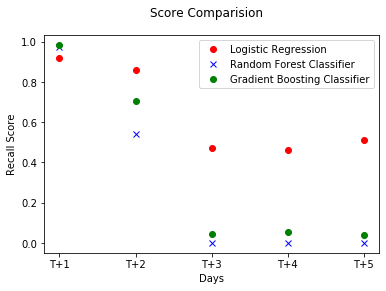

In [41]:
fig, ax = plt.subplots()
ax.plot(['T+1','T+2','T+3','T+4','T+5'],lr1RecallScore, 'ro', label='Logistic Regression')
ax.plot(['T+1','T+2','T+3','T+4','T+5'],RF1RecallScore, 'bx', label='Random Forest Classifier')
ax.plot(['T+1','T+2','T+3','T+4','T+5'],GB1RecallScore,'go',label='Gradient Boosting Classifier')
leg = ax.legend();
fig.suptitle('Score Comparision')
plt.xlabel('Days')
plt.ylabel('Recall Score')

Sampling Plot

Text(0, 0.5, 'Recall Score')

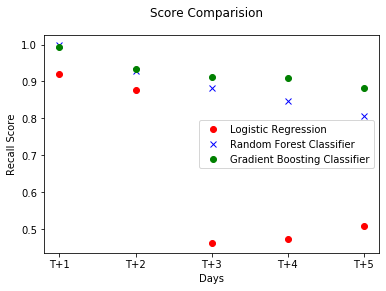

In [42]:
#Sampling Ratio 0.6
fig, ax = plt.subplots()
ax.plot(['T+1','T+2','T+3','T+4','T+5'],lr2RecallScore, 'ro', label='Logistic Regression')
ax.plot(['T+1','T+2','T+3','T+4','T+5'],RF2RecallScore, 'bx', label='Random Forest Classifier')
ax.plot(['T+1','T+2','T+3','T+4','T+5'],GB2RecallScore,'go',label='Gradient Boosting Classifier')
leg = ax.legend();
fig.suptitle('Score Comparision')
plt.xlabel('Days')
plt.ylabel('Recall Score')